In [1]:
# 1. ENVIRONMENT SETUP & CONFIGURATION
import os
import sys
import json
import logging
import pyotp
import requests
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from typing import Optional, Union, Tuple, Dict
from kiteconnect import KiteConnect
from dotenv import load_dotenv

# Force CPU for absolute stability
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# --- PERSISTENCE TOGGLE ---
USE_PRETRAINED_WEIGHTS = True  # True: Load weights | False: Fresh Training

# --- CONFIGURATION ---
DATA_CONFIG = {
    'window_size': 21,
    'feature_cols': [
        'norm_daily_return', 'norm_monthly_return', 'norm_quarterly_return',
        'norm_biannual_return', 'norm_annual_return', 'macd_8_24',
        'macd_16_48', 'macd_32_96', 'volatility_20d', 'volatility_60d',
        'cp_rl_21', 'cp_score_21',
    ]
}
BPS_COST = 0.0010 


2026-02-14 09:07:57.681334: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-14 09:07:57.746589: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-14 09:07:59.052015: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
# 2. ZERODHA DATA ENGINE (STANDALONE)

class KiteAuth:
    def __init__(self):
        load_dotenv()
        self.api_key = os.getenv("ZERODHA_API_KEY")
        self.api_secret = os.getenv("ZERODHA_API_SECRET")
        self.totp_secret = os.getenv("ZERODHA_TOTP_SECRET")
        self.user_id = os.getenv("ZERODHA_USER_ID")
        self.password = os.getenv("ZERODHA_PASSWORD")
        self.token_file = os.path.expanduser("~/.zerodha_access_token")

    def get_session(self):
        if os.path.exists(self.token_file):
            try:
                with open(self.token_file, 'r') as f:
                    access_token = f.read().strip()
                kite = KiteConnect(api_key=self.api_key)
                kite.set_access_token(access_token)
                kite.profile() # Verify
                return kite
            except: pass
        
        print("Starting Zerodha Authentication Flow...")
        try:
            totp = pyotp.TOTP(self.totp_secret).now()
            with requests.Session() as s:
                r = s.post("https://kite.zerodha.com/api/login", data={"user_id": self.user_id, "password": self.password})
                rid = r.json()["data"]["request_id"]
                s.post("https://kite.zerodha.com/api/twofa", data={"user_id": self.user_id, "request_id": rid, "twofa_value": totp})
                r = s.get(f"https://kite.trade/connect/login?api_key={self.api_key}")
                token = r.url.split("request_token=")[1].split("&")[0]
                kite = KiteConnect(api_key=self.api_key)
                sess = kite.generate_session(token, api_secret=self.api_secret)
                with open(self.token_file, 'w') as f: f.write(sess["access_token"])
                kite.set_access_token(sess["access_token"])
                return kite
        except Exception as e:
            print(f"Auth Failed: {e}")
            return None

class KiteFetcher:
    def __init__(self, kite):
        self.kite = kite

    def fetch_daily(self, symbol, exchange, start="2020-01-01", end=None):
        if end is None: end = datetime.now().strftime("%Y-%m-%d")
        all_ins = self.kite.instruments(exchange)
        
        # Exact match first
        match = [i for i in all_ins if i['tradingsymbol'] == symbol]
        
        # If no exact match, find nearest-expiry FUT contract matching the symbol prefix
        if not match:
            fut_matches = [i for i in all_ins if i['tradingsymbol'].startswith(symbol) 
                          and i['instrument_type'] == 'FUT'
                          and i['expiry'] and i['expiry'] >= datetime.now().date()]
            fut_matches.sort(key=lambda x: x['expiry'])
            if fut_matches:
                match = [fut_matches[0]]
                print(f"   Resolved {symbol} -> {match[0]['tradingsymbol']} (expiry: {match[0]['expiry']})")
        
        if not match:
            raise ValueError(f"No instrument found for '{symbol}' on {exchange}")
        
        token = match[0]['instrument_token']
        
        # Fetch in chunks of 1900 days (API limit is 2000)
        dt_start = datetime.strptime(start, "%Y-%m-%d")
        dt_end = datetime.strptime(end, "%Y-%m-%d")
        chunk_days = 1900
        all_records = []
        
        cur = dt_start
        while cur < dt_end:
            chunk_end = min(cur + timedelta(days=chunk_days), dt_end)
            records = self.kite.historical_data(
                token, cur.strftime("%Y-%m-%d"), chunk_end.strftime("%Y-%m-%d"),
                "day", continuous=True
            )
            all_records.extend(records)
            cur = chunk_end + timedelta(days=1)
        
        df = pd.DataFrame(all_records)
        df['date'] = pd.to_datetime(df['date']).dt.tz_localize(None)
        return df.set_index('date').sort_index()

In [3]:
# 3. AFML PREPROCESSING (SAMPLING & LABELING)

def get_daily_vol(close, span=50):
    """Exponentially weighted moving standard deviation of log returns."""
    return np.log(close).diff().ewm(span=span).std()

def cusum_filter(close, threshold):
    """Symmetric CUSUM Filter for event detection."""
    log_ret = np.log(close / close.shift(1)).dropna()
    events, s_pos, s_neg = [], 0.0, 0.0
    for t, ret in log_ret.items():
        h = threshold.loc[t] if isinstance(threshold, pd.Series) else threshold
        s_pos, s_neg = max(0.0, s_pos + ret), min(0.0, s_neg + ret)
        if s_pos > h or s_neg < -h:
            events.append(t); s_pos, s_neg = 0.0, 0.0
    return pd.DatetimeIndex(events)

def triple_barrier_labels(close, events, pt_sl=(1.0, 1.0), num_days=5):
    """Triple Barrier Labeling: Profit-Take, Stop-Loss, and Time-Out."""
    vol = get_daily_vol(close)
    records = []
    for t0 in events:
        if t0 not in close.index: continue
        idx = close.index.get_loc(t0)
        loc_t1 = min(idx + num_days, len(close)-1)
        t1 = close.index[loc_t1]
        path = close.loc[t0:t1]
        log_ret = np.log(path / close.loc[t0])
        u, l = pt_sl[0]*vol.loc[t0], -pt_sl[1]*vol.loc[t0]
        t_u = log_ret[log_ret >= u].index[0] if not log_ret[log_ret >= u].empty else pd.NaT
        t_l = log_ret[log_ret <= l].index[0] if not log_ret[log_ret <= l].empty else pd.NaT
        first = min([t for t in [t1, t_u, t_l] if pd.notna(t)])
        
        realized_ret = log_ret.loc[first]
        records.append({
            "ret": realized_ret, 
            "bin": int(np.sign(realized_ret)) if abs(realized_ret) > 1e-6 else 0, 
            "t_end": first
        })
    return pd.DataFrame(records, index=events[:len(records)])

def meta_labeling(primary_preds, true_labels):
    """1 if primary model correctly predicted direction, 0 otherwise."""
    common_idx = primary_preds.index.intersection(true_labels.index)
    p = primary_preds.loc[common_idx]
    l = true_labels.loc[common_idx]
    meta = np.where((p != 0) & (l != 0) & (np.sign(p) == np.sign(l)), 1, 0)
    return pd.Series(meta, index=common_idx)


In [4]:
# 4. FEATURE ENGINEERING PIPELINE

def engineer_features(df, symbol="SILVER"):
    """
    Standard production feature engineering.
    Matches the logic used in the training scripts.
    """
    df = df.copy()
    
    # Fundamental Returns
    df['DAILY_RET_RAW'] = df['close'].pct_change(1).fillna(0)
    df['norm_daily_return'] = df['DAILY_RET_RAW']
    df['norm_monthly_return'] = df['close'].pct_change(21).fillna(0)
    df['norm_quarterly_return'] = df['close'].pct_change(63).fillna(0)
    df['norm_biannual_return'] = df['close'].pct_change(126).fillna(0)
    df['norm_annual_return'] = df['close'].pct_change(252).fillna(0)
    
    # MACD Features (adjust=False is production standard)
    for f, s in [(8, 24), (16, 48), (32, 96)]:
        df[f'macd_{f}_{s}'] = (
            df['close'].ewm(span=f, adjust=False).mean() - 
            df['close'].ewm(span=s, adjust=False).mean()
        )
    
    # Volatility
    for w in [20, 60]:
        df[f'volatility_{w}d'] = df['DAILY_RET_RAW'].rolling(w).std().fillna(0)
    
    # Change Point Detection (CPD) - Injecting mock/zero if missing
    cpd_path = f"data/cpd/{symbol}_cpd_21.csv"
    if os.path.exists(cpd_path):
        cpd = pd.read_csv(cpd_path, index_col=0, parse_dates=True).reindex(df.index)
        df['cp_rl_21'] = cpd['cp_location_norm'].fillna(0)
        df['cp_score_21'] = cpd['cp_score'].fillna(0)
    else:
        df['cp_rl_21'], df['cp_score_21'] = 0.0, 0.0
        
    # Final Scaling: Z-Score (computed over the available history for stability)
    f_cols = DATA_CONFIG['feature_cols']
    for col in f_cols:
        m, s = df[col].mean(), df[col].std()
        df[col] = (df[col] - m) / (s if s > 1e-9 else 1.0)
        
    return df.dropna()

def extract_sequences(df, events, window_size=21):
    """
    Extracts (window_size, num_features) arrays for each event timestamp.
    """
    f_cols = DATA_CONFIG['feature_cols']
    X, valid_events = [], []
    for t in events:
        if t not in df.index: continue
        idx = df.index.get_loc(t)
        if idx < window_size: continue
        
        # Window ends AT the event timestamp (exclusive of the event's return)
        # or inclusive? In production, features are typically lagged or windowed up to t-1.
        # Here we follow the logic: window is [t-window_size : t]
        window = df[f_cols].iloc[idx-window_size : idx].values.astype(np.float32)
        X.append(window)
        valid_events.append(t)
        
    return np.array(X), pd.DatetimeIndex(valid_events)


In [5]:
# 5. MOMENTUM TRANSFORMER ARCHITECTURE (PRODUCTION GRADE)

@tf.keras.utils.register_keras_serializable()
class GluLayer(layers.Layer):
    def __init__(self, hidden_size, dropout_rate=None, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.hidden_size, self.dropout_rate, self.activation = hidden_size, dropout_rate, activation
        self.dropout = layers.Dropout(dropout_rate) if dropout_rate else None
        self.activation_layer = layers.Dense(hidden_size, activation=activation)
        self.gated_layer = layers.Dense(hidden_size, activation="sigmoid")
    def call(self, inputs):
        x = self.dropout(inputs) if self.dropout else inputs
        return layers.Multiply()([self.activation_layer(x), self.gated_layer(x)]), self.gated_layer(x)
    def get_config(self): 
        return {**super().get_config(), "hidden_size": self.hidden_size, "dropout_rate": self.dropout_rate, "activation": self.activation}

@tf.keras.utils.register_keras_serializable()
class GatedResidualNetwork(layers.Layer):
    def __init__(self, hidden_size, output_size=None, dropout_rate=None, context_size=None, **kwargs):
        super().__init__(**kwargs)
        self.hidden_size, self.output_size, self.dropout_rate, self.context_size = hidden_size, output_size or hidden_size, dropout_rate, context_size
        self.skip_layer, self.layer1, self.layer2 = None, layers.Dense(hidden_size), layers.Dense(hidden_size)
        self.context_layer = layers.Dense(hidden_size, use_bias=False) if context_size else None
        self.glu = GluLayer(self.output_size, dropout_rate=dropout_rate)
        self.add, self.norm = layers.Add(), layers.LayerNormalization()
    def call(self, inputs, context=None, return_gate=False):
        if self.skip_layer is None and inputs.shape[-1] != self.output_size: self.skip_layer = layers.Dense(self.output_size)
        skip = self.skip_layer(inputs) if self.skip_layer else inputs
        x = self.layer1(inputs)
        if context is not None and self.context_layer: x = x + self.context_layer(context)
        x = self.layer2(tf.nn.elu(x))
        glu_out, gate = self.glu(x)
        out = self.norm(self.add([skip, glu_out]))
        return (out, gate) if return_gate else out
    def get_config(self): 
        return {**super().get_config(), "hidden_size": self.hidden_size, "output_size": self.output_size, "dropout_rate": self.dropout_rate}

@tf.keras.utils.register_keras_serializable()
class VariableSelectionNetwork(layers.Layer):
    def __init__(self, num_inputs, hidden_size, dropout_rate=None, context_size=None, **kwargs):
        super().__init__(**kwargs)
        self.num_inputs, self.hidden_size, self.dropout_rate = num_inputs, hidden_size, dropout_rate
        self.selection_grn = GatedResidualNetwork(hidden_size, output_size=num_inputs, dropout_rate=dropout_rate, context_size=context_size)
        self.softmax_weighting = layers.Softmax(axis=-1)
        self.input_grns = [GatedResidualNetwork(hidden_size, dropout_rate=dropout_rate) for _ in range(num_inputs)]
    def call(self, inputs, context=None):
        shp = tf.shape(inputs)
        flat = tf.reshape(inputs, [shp[0], shp[1], self.num_inputs * self.hidden_size])
        weights = self.softmax_weighting(self.selection_grn(flat, context=context, return_gate=True)[1])
        processed = tf.stack([self.input_grns[i](inputs[..., i, :]) for i in range(self.num_inputs)], axis=-2)
        return tf.reduce_sum(tf.expand_dims(weights, -1) * processed, axis=-2), weights
    def get_config(self): 
        return {**super().get_config(), "num_inputs": self.num_inputs, "hidden_size": self.hidden_size, "dropout_rate": self.dropout_rate}

@tf.keras.utils.register_keras_serializable()
class ScaledDotProductAttention(layers.Layer):
    def __init__(self, dropout_rate=0.0, **kwargs):
        super().__init__(**kwargs)
        self.dropout_rate = dropout_rate
        self.dropout, self.activation = layers.Dropout(dropout_rate), layers.Activation("softmax")
    def call(self, q, k, v, mask=None):
        attn = tf.matmul(q, k, transpose_b=True) / tf.sqrt(tf.cast(tf.shape(q)[-1], tf.float32))
        if mask is not None: attn += (1.0 - tf.cast(mask, tf.float32)) * -1e9
        attn = self.dropout(self.activation(attn))
        return tf.matmul(attn, v), attn
    def get_config(self): return {**super().get_config(), "dropout_rate": self.dropout_rate}

@tf.keras.utils.register_keras_serializable()
class InterpretableMultiHeadAttention(layers.Layer):
    def __init__(self, num_heads, d_model, dropout_rate=0.0, **kwargs):
        super().__init__(**kwargs)
        self.num_heads, self.d_model, self.dropout_rate = num_heads, d_model, dropout_rate
        self.d_head = d_model // num_heads
        self.q_layers = [layers.Dense(self.d_head, use_bias=False) for _ in range(num_heads)]
        self.k_layers = [layers.Dense(self.d_head, use_bias=False) for _ in range(num_heads)]
        self.v_layer = layers.Dense(self.d_head, use_bias=False)
        self.attention = ScaledDotProductAttention(dropout_rate)
        self.w_o, self.dropout = layers.Dense(d_model, use_bias=False), layers.Dropout(dropout_rate)
    def call(self, q, k, v, mask=None):
        vs = self.v_layer(v)
        hs, attns = [], []
        for i in range(self.num_heads):
            h, a = self.attention(self.q_layers[i](q), self.k_layers[i](k), vs, mask)
            hs.append(h); attns.append(a)
        out = self.w_o(tf.reduce_mean(tf.stack(hs, 0), 0) if self.num_heads > 1 else hs[0])
        return self.dropout(out), tf.stack(attns, 1)
    def get_config(self): 
        return {**super().get_config(), "num_heads": self.num_heads, "d_model": self.d_model, "dropout_rate": self.dropout_rate}

@tf.keras.utils.register_keras_serializable()
class MomentumTransformer(Model):
    def __init__(self, time_steps, input_size, output_size, hidden_size, num_heads, dropout_rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.time_steps, self.input_size, self.output_size, self.hidden_size, self.num_heads, self.dropout_rate = time_steps, input_size, output_size, hidden_size, num_heads, dropout_rate
        self.feature_embeddings = [layers.Dense(hidden_size) for _ in range(input_size)]
        self.var_selection = VariableSelectionNetwork(input_size, hidden_size, dropout_rate)
        self.lstm, self.lstm_gate, self.lstm_norm = layers.LSTM(hidden_size, return_sequences=True, dropout=dropout_rate), GluLayer(hidden_size), layers.LayerNormalization()
        self.post_lstm_grn = GatedResidualNetwork(hidden_size, dropout_rate=dropout_rate)
        self.attention, self.attn_gate, self.attn_norm = InterpretableMultiHeadAttention(num_heads, hidden_size, dropout_rate), GluLayer(hidden_size), layers.LayerNormalization()
        self.post_attn_grn, self.output_gate, self.output_norm = GatedResidualNetwork(hidden_size, dropout_rate=dropout_rate), GluLayer(hidden_size), layers.LayerNormalization()
        self.final_dense = layers.Dense(output_size, activation="tanh")
    def call(self, x, return_weights=False):
        e = tf.stack([self.feature_embeddings[i](x[..., i:i+1]) for i in range(self.input_size)], axis=2)
        sel, v_w = self.var_selection(e)
        t = self.lstm_norm(sel + self.lstm_gate(self.lstm(sel))[0])
        sm = tf.linalg.band_part(tf.ones((tf.shape(x)[0], tf.shape(x)[1], tf.shape(x)[1])), -1, 0)
        a_out, a_w = self.attention(self.post_lstm_grn(t), self.post_lstm_grn(t), self.post_lstm_grn(t), mask=sm)
        a_lay = self.attn_norm(self.post_lstm_grn(t) + self.attn_gate(a_out)[0])
        out = self.final_dense(self.output_norm(t + self.output_gate(self.post_attn_grn(a_lay))[0]))
        return (out, {'vsn_weights': v_w, 'attn_weights': a_w}) if return_weights else out
    def get_config(self): 
        return {**super().get_config(), "time_steps": self.time_steps, "input_size": self.input_size}

@tf.keras.utils.register_keras_serializable()
class SharpeLoss(tf.keras.losses.Loss):
    def __init__(self, output_size=1, **kwargs):
        super().__init__(**kwargs)
        self.output_size = output_size
    def call(self, y_true, y_pred):
        rets = y_pred * y_true
        m, s = tf.reduce_mean(rets), tf.math.reduce_std(rets)
        return - (m / (s + 1e-9)) * tf.sqrt(252.0)
    def get_config(self):
        return {**super().get_config(), "output_size": self.output_size}

In [6]:
# 6. TRAINING & INFERENCE ENGINE

def build_models():
    """Initializes the Primary and Meta models with production parameters."""
    window = DATA_CONFIG['window_size']
    n_feat = len(DATA_CONFIG['feature_cols'])
    
    # Primary Model (TMT) - build via dummy forward pass
    pm = MomentumTransformer(window, n_feat, 1, 64, 4)
    pm(np.zeros((1, window, n_feat), dtype=np.float32))
    pm.compile(optimizer=keras.optimizers.Adam(1e-4), loss=SharpeLoss())
    
    # Meta Model (Architecture matches Primary but with BinaryCrossentropy)
    inputs = keras.Input(shape=(window, n_feat))
    base_mm = MomentumTransformer(window, n_feat, 1, 64, 4)
    # Extract last time step for classification
    mm_out = base_mm(inputs)
    mm_final = layers.Dense(1, activation="sigmoid")(layers.Lambda(lambda z: z[:, -1, :])(mm_out))
    mm = Model(inputs, mm_final)
    mm.compile(optimizer=keras.optimizers.Adam(1e-4), loss="binary_crossentropy", metrics=["accuracy"])
    
    return pm, mm

def calculate_metrics(returns, weights=None):
    """Calculates Sharpe, MDD, and Net Returns including BPS costs."""
    returns = np.nan_to_num(returns)
    def net_mdd(r):
        c = np.exp(np.cumsum(r))
        p = np.maximum.accumulate(c)
        return float(np.min((c - p) / p)) if len(p) > 0 and np.max(p) > 0 else 0
    
    net_r = returns.copy()
    cost_total = 0
    if weights is not None:
        cost_series = np.abs(np.diff(np.nan_to_num(weights), prepend=0)) * BPS_COST
        net_r -= cost_series
        cost_total = cost_series.sum()
    
    return {
        'total_return': float(np.exp(np.sum(net_r)) - 1),
        'sharpe': (np.sqrt(252) * net_r.mean() / net_r.std()) if net_r.std() > 1e-9 else 0,
        'mdd': net_mdd(net_r),
        'costs': float(cost_total)
    }

def optimize_veto_threshold(eval_df):
    """Searches for the 'Balanced' threshold providing crash protection + net profit."""
    print("Searching for Optimal Balanced Threshold...")
    thresholds = np.linspace(eval_df['confidence'].min(), eval_df['confidence'].max(), 50)
    sweep = []
    for t in thresholds:
        m_w = (eval_df['primary'] * np.where(eval_df['confidence'] > t, 1, 0)).shift(1).fillna(0)
        perf = calculate_metrics(eval_df['DAILY_RET_RAW'] * m_w, weights=m_w.values)
        sweep.append({'threshold': t, **perf})
    
    sweep_df = pd.DataFrame(sweep)
    # Balanced Rule: Max Return where MDD > -30%
    safe = sweep_df[sweep_df['mdd'] > -0.30]
    best_t = safe.loc[safe['total_return'].idxmax(), 'threshold'] if not safe.empty else sweep_df.loc[sweep_df['total_return'].idxmax(), 'threshold']
    return best_t, sweep_df

1. Fetching SILVER data from Zerodha...
   Resolved SILVER -> SILVERM26FEBFUT (expiry: 2026-02-27)
   Historical rows: 1567
2. Engineering Features & Scaling...
3a. Loading Pre-trained Models...


2026-02-14 09:08:02.377723: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2026-02-14 09:08:02.377759: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:160] env: CUDA_VISIBLE_DEVICES="-1"
2026-02-14 09:08:02.377766: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] CUDA_VISIBLE_DEVICES is set to -1 - this hides all GPUs from CUDA
2026-02-14 09:08:02.377770: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:171] verbose logging is disabled. Rerun with verbose logging (usually --v=1 or --vmodule=cuda_diagnostics=1) to get more diagnostic output from this module
2026-02-14 09:08:02.377775: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:176] retrieving CUDA diagnostic information for host: ip-172-31-36-166
2026-02-14 09:08:02.377778: I external/local_xla/xla/stream_executor/c

4. Executing In-Sample Backtest...


/home/ubuntu/Desktop/7hills/QuantKubera/qk_venv/lib/python3.12/site-packages/keras/src/layers/layer.py:982: UserWarning: Layer 'interpretable_multi_head_attention' (of type InterpretableMultiHeadAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/home/ubuntu/Desktop/7hills/QuantKubera/qk_venv/lib/python3.12/site-packages/keras/src/layers/layer.py:982: UserWarning: Layer 'interpretable_multi_head_attention_1' (of type InterpretableMultiHeadAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Searching for Optimal Balanced Threshold...
   Optimal Veto Threshold: -0.1393


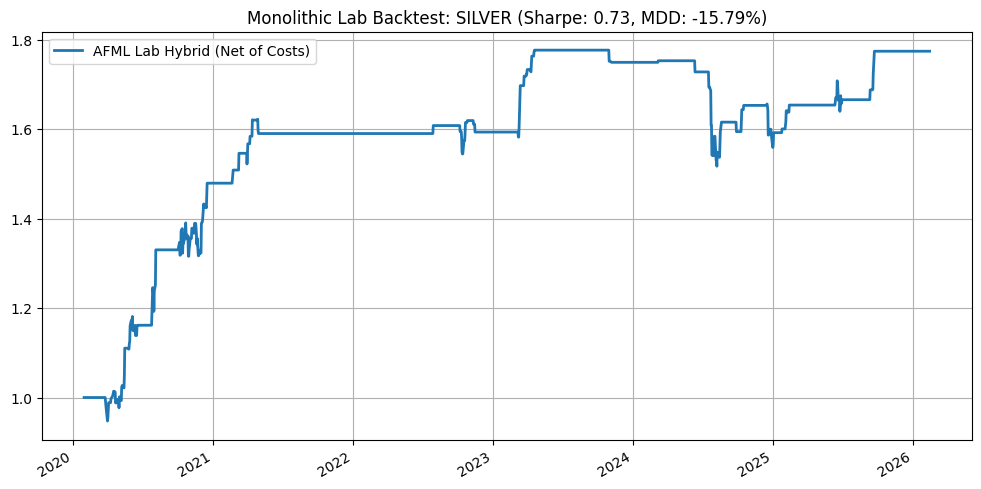


--- FINAL LAB METRICS ---
total_return: 0.5485
sharpe: 0.7337
mdd: -0.1579
costs: 0.1360


In [7]:
# 7. UNIFIED LAB EXECUTION (END-TO-END)

def run_monolith_lab(symbol="SILVER", exchange="MCX", start="2020-01-01"):
    """Executes the complete AFML cycle: Data -> Features -> Sampling -> Train/Load -> Backtest."""
    try:
        # A. DATA ACQUISITION
        print(f"1. Fetching {symbol} data from Zerodha...")
        auth = KiteAuth()
        kite = auth.get_session()
        if not kite: return print("Kite Authentication Failed.")
        
        fetcher = KiteFetcher(kite)
        raw_df = fetcher.fetch_daily(symbol, exchange, start)
        print(f"   Historical rows: {len(raw_df)}")
        
        # B. FEATURE ENGINEERING
        print("2. Engineering Features & Scaling...")
        df_full = engineer_features(raw_df, symbol)
        
        # C. MODELS TRAINING/LOADING
        custom_objects = {
            'MomentumTransformer': MomentumTransformer,
            'SharpeLoss': SharpeLoss,
            'GluLayer': GluLayer,
            'GatedResidualNetwork': GatedResidualNetwork,
            'VariableSelectionNetwork': VariableSelectionNetwork,
            'ScaledDotProductAttention': ScaledDotProductAttention,
            'InterpretableMultiHeadAttention': InterpretableMultiHeadAttention,
        }
        
        if USE_PRETRAINED_WEIGHTS:
            print("3a. Loading Pre-trained Models...")
            pm = keras.models.load_model("models/afml_primary_v2/afml_primary_model.keras",
                                         custom_objects=custom_objects)
            mm = keras.models.load_model("models/afml_meta_v1/best_meta_model.keras",
                                         custom_objects=custom_objects, safe_mode=False)
        else:
            print("3b. Running Ground-up Training Cycle...")
            pm, mm = build_models()
            # 1. Primary Training Set (All-time samples for Sharpe optimization)
            p_events = cusum_filter(df_full['close'], 0.05)
            X_p, _ = extract_sequences(df_full, p_events)
            y_p = df_full['DAILY_RET_RAW'].reindex(p_events).values.astype(np.float32)
            pm.fit(X_p, y_p, epochs=20, batch_size=64, verbose=1)
            
            # 2. Meta Training Set (Triple Barrier Labels)
            labels = triple_barrier_labels(df_full['close'], p_events, pt_sl=(1.2, 1.2), num_days=10)
            X_m, valid_idx = extract_sequences(df_full, labels.index)
            p_preds = np.sign(pm.predict(X_m, verbose=0)[:, -1, 0])
            y_m = meta_labeling(pd.Series(p_preds, index=valid_idx), labels['bin']).values.astype(np.float32)
            mm.fit(X_m, y_m, epochs=20, batch_size=64, verbose=1)

        # D. STRATEGY INFERENCE & OPTIMIZATION
        print("4. Executing In-Sample Backtest...")
        eval_X, eval_idx = extract_sequences(df_full, df_full.index[DATA_CONFIG['window_size']:])
        p_out = pm.predict(eval_X, verbose=0)
        p_signs = np.sign(p_out[:, -1, 0])
        conf_out = mm.predict(eval_X, verbose=0)[:, 0]
        
        eval_df = df_full[['DAILY_RET_RAW']].reindex(eval_idx)
        eval_df['primary'] = p_signs
        eval_df['confidence'] = conf_out
        
        best_t, sweep_df = optimize_veto_threshold(eval_df)
        print(f"   Optimal Veto Threshold: {best_t:.4f}")
        
        # E. VISUALIZATION
        m_w = (eval_df['primary'] * np.where(eval_df['confidence'] > best_t, 1, 0)).shift(1).fillna(0)
        perf = calculate_metrics(eval_df['DAILY_RET_RAW'] * m_w, weights=m_w.values)
        
        plt.figure(figsize=(12, 6))
        np.exp((eval_df['DAILY_RET_RAW'] * m_w).cumsum()).plot(label="AFML Lab Hybrid (Net of Costs)", lw=2)
        plt.title(f"Monolithic Lab Backtest: {symbol} (Sharpe: {perf['sharpe']:.2f}, MDD: {perf['mdd']:.2%})")
        plt.grid(True); plt.legend(); plt.show()
        
        print("\n--- FINAL LAB METRICS ---")
        for k, v in perf.items(): print(f"{k}: {v:.4f}")

    except Exception as e:
        print(f"Lab Execution Failed: {e}")
        import traceback; traceback.print_exc()

# --- RUN THE LAB ---
run_monolith_lab()

In [8]:
# 8. VECTORBTPRO TEARSHEET & TRADE ANALYSIS
import vectorbtpro as vbt

# --- Re-run signal generation (uses variables from cell 7's last run) ---
print("Rebuilding signals for VBT analysis...")

auth = KiteAuth()
kite = auth.get_session()
fetcher = KiteFetcher(kite)
raw_df = fetcher.fetch_daily("SILVER", "MCX", "2020-01-01")
df_full = engineer_features(raw_df, "SILVER")

custom_objects = {
    'MomentumTransformer': MomentumTransformer,
    'SharpeLoss': SharpeLoss,
    'GluLayer': GluLayer,
    'GatedResidualNetwork': GatedResidualNetwork,
    'VariableSelectionNetwork': VariableSelectionNetwork,
    'ScaledDotProductAttention': ScaledDotProductAttention,
    'InterpretableMultiHeadAttention': InterpretableMultiHeadAttention,
}
pm = keras.models.load_model("models/afml_primary_v2/afml_primary_model.keras",
                             custom_objects=custom_objects)
mm = keras.models.load_model("models/afml_meta_v1/best_meta_model.keras",
                             custom_objects=custom_objects, safe_mode=False)

eval_X, eval_idx = extract_sequences(df_full, df_full.index[DATA_CONFIG['window_size']:])
p_signs = np.sign(pm.predict(eval_X, verbose=0)[:, -1, 0])
conf_out = mm.predict(eval_X, verbose=0)[:, 0]

eval_df = df_full[['DAILY_RET_RAW', 'close']].reindex(eval_idx).copy()
eval_df['primary'] = p_signs
eval_df['confidence'] = conf_out

best_t, _ = optimize_veto_threshold(eval_df)
print(f"Veto threshold: {best_t:.4f}")

# --- Build position series ---
raw_signal = eval_df['primary'] * np.where(eval_df['confidence'] > best_t, 1, 0)
position = raw_signal.shift(1).fillna(0)  # signal at t -> position at t+1
close = eval_df['close']

# --- Derive entry/exit signals ---
long_entries  = (position > 0) & (position.shift(1).fillna(0) <= 0)
long_exits    = (position <= 0) & (position.shift(1).fillna(0) > 0)
short_entries = (position < 0) & (position.shift(1).fillna(0) >= 0)
short_exits   = (position >= 0) & (position.shift(1).fillna(0) < 0)

# --- VBT Portfolio (long/short mode, no direction param) ---
pf = vbt.Portfolio.from_signals(
    close=close,
    long_entries=long_entries,
    long_exits=long_exits,
    short_entries=short_entries,
    short_exits=short_exits,
    fees=0.0005,
    slippage=0.0005,
    freq='1D',
    init_cash=1_000_000,
)

print("\n" + "="*60)
print("        VECTORBTPRO FULL STATS")
print("="*60)
print(pf.stats())

print("\n" + "="*60)
print("        TRADE LOG")
print("="*60)
print(pf.trades.records_readable.to_string())

print(f"\nTotal trades: {pf.trades.count}")
print(f"Win rate: {pf.trades.win_rate:.2%}")
print(f"Profit factor: {pf.trades.profit_factor:.2f}")
print(f"Avg P&L: {pf.trades.pnl.mean():.2f}")
print(f"Expectancy: {pf.trades.expectancy:.2f}")

Rebuilding signals for VBT analysis...
   Resolved SILVER -> SILVERM26FEBFUT (expiry: 2026-02-27)


/home/ubuntu/Desktop/7hills/QuantKubera/qk_venv/lib/python3.12/site-packages/keras/src/layers/layer.py:982: UserWarning:

Layer 'interpretable_multi_head_attention_2' (of type InterpretableMultiHeadAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.

/home/ubuntu/Desktop/7hills/QuantKubera/qk_venv/lib/python3.12/site-packages/keras/src/layers/layer.py:982: UserWarning:

Layer 'interpretable_multi_head_attention_3' (of type InterpretableMultiHeadAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.

/home/ubuntu/Desktop/7hills/QuantKubera/qk_venv/lib/python3.12/site-packages/keras/src/layers/layer.py:982: UserWarning:

Layer 'interpretable_multi_head_attention_2' (of type InterpretableMultiHeadAttention) was p

Searching for Optimal Balanced Threshold...
Veto threshold: -0.1393

        VECTORBTPRO FULL STATS


/home/ubuntu/Desktop/7hills/QuantKubera/qk_venv/lib/python3.12/site-packages/vectorbtpro/utils/datetime_.py:615: VBTWarning: Ambiguous frequency <Day>
/home/ubuntu/Desktop/7hills/QuantKubera/qk_venv/lib/python3.12/site-packages/vectorbtpro/utils/datetime_.py:615: VBTWarning: Ambiguous frequency <365 * Days>
/home/ubuntu/Desktop/7hills/QuantKubera/qk_venv/lib/python3.12/site-packages/vectorbtpro/utils/datetime_.py:615: VBTWarning: Ambiguous frequency <Day>
/home/ubuntu/Desktop/7hills/QuantKubera/qk_venv/lib/python3.12/site-packages/vectorbtpro/utils/datetime_.py:615: VBTWarning: Ambiguous frequency <Day>
/home/ubuntu/Desktop/7hills/QuantKubera/qk_venv/lib/python3.12/site-packages/vectorbtpro/utils/datetime_.py:615: VBTWarning: Ambiguous frequency <Day>
/home/ubuntu/Desktop/7hills/QuantKubera/qk_venv/lib/python3.12/site-packages/vectorbtpro/utils/datetime_.py:615: VBTWarning: Ambiguous frequency <Day>
/home/ubuntu/Desktop/7hills/QuantKubera/qk_venv/lib/python3.12/site-packages/vectorbtpr

Start Index                         2020-01-30 00:00:00
End Index                           2026-02-13 00:00:00
Total Duration                       1546 days 00:00:00
Start Value                                   1000000.0
Min Value                                 955689.862737
Max Value                                1320715.196134
End Value                                1239878.284824
Total Return [%]                              23.987828
Benchmark Return [%]                         431.768015
Position Coverage [%]                         11.772316
Max Gross Exposure [%]                            100.0
Max Drawdown [%]                              15.575994
Max Drawdown Duration                1362 days 00:00:00
Total Orders                                        136
Total Fees Paid                            81169.905776
Total Trades                                         68
Win Rate [%]                                  45.588235
Best Trade [%]                                 1

/home/ubuntu/Desktop/7hills/QuantKubera/qk_venv/lib/python3.12/site-packages/vectorbtpro/utils/datetime_.py:615: VBTWarning: Ambiguous frequency <Day>
/home/ubuntu/Desktop/7hills/QuantKubera/qk_venv/lib/python3.12/site-packages/vectorbtpro/utils/datetime_.py:615: VBTWarning: Ambiguous frequency <365 * Days>
